# Investigating Jeopardy Questions and Answers

### Load Data

In [1]:
import pandas as pd
jeopardy = pd.read_csv('jeopardy.csv')
jeopardy.head(5)

,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams


### Clean Data

In [2]:
jeopardy.columns = ['Show Number', 'Air Date', 'Round', 'Category', 'Value',
       'Question', 'Answer']

#jeopardy.columns = jeopardy.columns.apply(lambda x: x.split())

In [3]:
import string
#normalize strings: remove punctuation and standardise case
def normalizeStr(s):
    s = s.lower()
    s = s.translate(str.maketrans("", "", string.punctuation))
    return s

In [4]:
jeopardy['clean_question'] = jeopardy['Question'].apply(lambda x: normalizeStr(x))
jeopardy['clean_answer'] = jeopardy['Answer'].apply(lambda x: normalizeStr(x))

In [5]:
#normalize numbers: remove punctuation, convert str to int
def normalizeDollar(s):
    s = normalizeStr(s)
    try:
        i = int(s)
    except ValueError as ex:
        i = 0
    return i

In [6]:
jeopardy['clean_value'] = jeopardy['Value'].apply(lambda x: normalizeDollar(x))

In [7]:
#clean date time
jeopardy['Air Date'] = pd.to_datetime(jeopardy['Air Date'])

In [8]:
jeopardy.head()

,Show Number,Air Date,Round,Category,Value,Question,Answer,clean_question,clean_answer,clean_value
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus,for the last 8 years of his life galileo was u...,copernicus,200
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe,no 2 1912 olympian football star at carlisle i...,jim thorpe,200
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona,the city of yuma in this state has a record av...,arizona,200
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's,in 1963 live on the art linkletter show this c...,mcdonalds,200
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams,signer of the dec of indep framer of the const...,john adams,200


### How often is the answer deducible from the question?

In [9]:
#keep lower case
stopwords = ['the']

In [10]:
def Q1(j_row):
    split_question = j_row['clean_question'].split(" ")
    #split_question = [word for word in split_question if word not in stopwords]
    
    split_answer = j_row['clean_answer'].split(" ")
    split_answer = [word for word in split_answer if word not in stopwords]
    if len(split_answer) == 0:
        return 0
    
    match_count = 0
    
    for word in split_answer:
        if word in split_question:
            match_count += 1
    
    return match_count / len(split_answer)

In [11]:
jeopardy['answer_in_question'] = jeopardy.apply(Q1, axis=1)
jeopardy['answer_in_question'] .mean()

0.05973712438535679

just under 6% of words in the answer can be found in the question on average. This is not a lot

(array([1.7411e+04, 5.5000e+01, 2.5100e+02, 5.6600e+02, 3.1000e+01,
        1.4400e+03, 1.0700e+02, 1.3000e+01, 3.0000e+00, 1.2200e+02]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

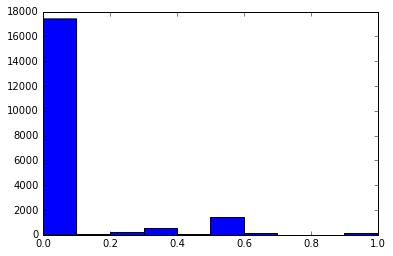

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(jeopardy['answer_in_question'])

### How often do new questions repeat older questios?

In [13]:
jeopardy = jeopardy.sort_values('Air Date')

In [14]:
question_overlap = []
terms_used = set()

for i, j_row in jeopardy.iterrows():
    split_question = j_row['clean_question'].split(" ")
    split_question = [word for word in split_question if len(word) >= 6]
    
    match_count = 0
    for word in split_question:
        if word in terms_used:
            match_count += 1
    for word in split_question:
        terms_used.add(word)
            
    if len(split_question) > 0:
        match_count /= len(split_question)
        
    question_overlap.append(match_count)

sum(question_overlap) / len(question_overlap)

0.6871242880966756

nearly 70% of questions share words (greater than 6 characters) with previous questions. Isolated words do not necessarily mean much but 70% is significant enough to investigate further

### High Value vs Low Value questions

In [15]:
def Q2(j_row):
    if j_row['clean_value'] > 800:
        return 1
    else:
        return 0

In [16]:
jeopardy['high_value'] = jeopardy.apply(Q2,axis=1)

In [17]:
jeopardy['high_value'].value_counts()

0    14265
1     5734
Name: high_value, dtype: int64

In [18]:
def Q3(word):
    low_count = 0
    high_count = 0
    for i, j_row in jeopardy.iterrows():
        split_question = j_row['clean_question'].split(" ")
        if word in split_question:
            if j_row['high_value'] == 1:
                high_count += 1
            else:
                low_count += 1
    return high_count, low_count

In [19]:
observed_expected = []
comparison_terms = list(terms_used)[:5]

for term in comparison_terms:
    observed_expected.append(Q3(term))

In [20]:
observed_expected

[(2, 10), (1, 0), (1, 0), (1, 3), (0, 1)]

In [21]:
comparison_terms[1]

'oesterreich'

In [22]:
high_value_count = jeopardy[jeopardy['high_value'] == 1].shape[0]
low_value_count = jeopardy[jeopardy['high_value'] == 0].shape[0]

In [23]:
from scipy.stats import chisquare
chi_squared = []
for li in observed_expected:
    total = sum(li)
    total_prop = total / jeopardy.shape[0]
    expected_high = total_prop * high_value_count
    expected_low = total_prop * low_value_count
    chi, p_value = chisquare(li, f_exp=[expected_high, expected_low])
    chi_squared.append((chi, p_value))

In [24]:
chi_squared

[(0.8456210901225915, 0.35779406898197064),
 (2.487792117195675, 0.11473257634454047),
 (2.487792117195675, 0.11473257634454047),
 (0.02636443308440769, 0.871013484688921),
 (0.401962846126884, 0.5260772985705469)]

The frequencies are all sufficiently low that a chi squared test is not valid. Additionally, none of these results are statistically significant.
#### End of Guided Steps